In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('UNSW_NB15_bayesian_enc_training_set.csv')
test = pd.read_csv('UNSW_NB15_bayesian_enc_testing_set.csv')

In [5]:
target = 'label'
IDcol = 'id'
ACcol = 'attack_cat'
train['label'].value_counts()

1    119341
0     56000
Name: label, dtype: int64

In [6]:
test['label'].value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [7]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        n_estimators=cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
        print(n_estimators)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print(dtrain_predictions)
    print(dtrain_predprob )
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    
#     Predict on testing data:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['label'], dtest_predprob))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.954683       0.006009       0.954162      0.005136
1           0.974192       0.004496       0.973776      0.005485
2           0.979690       0.002150       0.979447      0.002692
3           0.981730       0.001325       0.981518      0.002134
4           0.982909       0.001122       0.982751      0.001769
...              ...            ...            ...           ...
1479        0.996959       0.000135       0.993515      0.000336
1480        0.996959       0.000136       0.993515      0.000337
1481        0.996961       0.000136       0.993515      0.000337
1482        0.996962       0.000136       0.993516      0.000334
1483        0.996963       0.000137       0.993516      0.000334

[1484 rows x 4 columns]
1484


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1 0 1 ... 1 1 1]
[0.56998926 0.03172128 0.7467671  ... 0.9998087  0.99999225 0.99999225]

Model Report
Accuracy : 0.9723
AUC Score (Train): 0.996902
AUC Score (Test): 0.982351


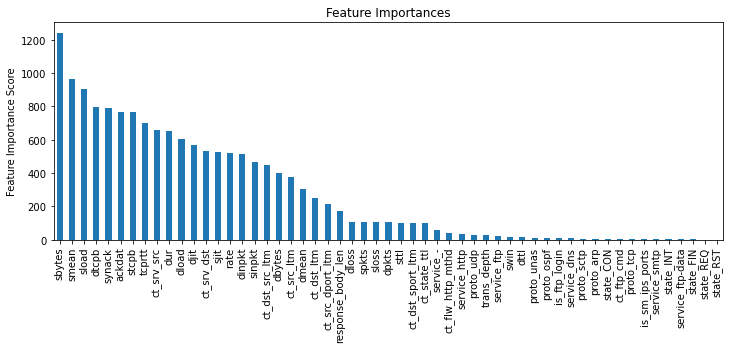

In [8]:
predictors = [x for x in train.columns if x not in [target, IDcol, ACcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1484,
        max_depth=4,
        min_child_weight=12,
        gamma=0.3,
        alpha = 0.05,
        subsample=0.6,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [10]:
# min_child_weight and max_depth
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1484, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([ 729.07954907,  721.28482447,  705.19047151, 1174.94892302,
         1136.23560157, 1093.03463545, 1663.33019209, 1565.91993876,
         1505.46529331, 2136.15486083, 1992.03475027, 1737.89494276]),
  'std_fit_time': array([  2.45632772,   6.09019432,   9.64368213,  28.52239646,
           7.20569349,  31.90376791,  48.27968294,  18.33054567,
          62.32298757,  66.45935853,  31.40903026, 227.89799608]),
  'mean_score_time': array([0.67495375, 0.71870208, 0.66245537, 1.07492681, 1.10304961,
         1.10929971, 1.58114166, 1.50927229, 1.65926151, 1.87799745,
         1.91549435, 1.7361239 ]),
  'std_score_time': array([0.05537125, 0.08148442, 0.03775702, 0.06874522, 0.02724108,
         0.04940706, 0.10976865, 0.05978014, 0.21063835, 0.12475602,
         0.0830285 , 0.26817182]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     Fal

In [11]:
# min_child_weight and max_depth
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1484, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([ 952.62244406,  931.34406414,  993.40586224, 1255.31639724,
         1292.63907628, 1224.4488276 , 1550.41826186, 1476.49587364,
         1260.52944708]),
  'std_fit_time': array([ 13.40141049,  13.16698588,  44.72532571,  31.06582183,
          30.95756219,  12.04244689,  25.51923375,  21.44286864,
         322.663164  ]),
  'mean_score_time': array([1.00930686, 1.09055128, 1.20190148, 1.28014998, 3.77934427,
         1.25090842, 9.42779179, 1.79039021, 1.38934655]),
  'std_score_time': array([0.08534727, 0.19272686, 0.2683603 , 0.24837499, 2.07052474,
         0.05440438, 7.67327306, 0.39540293, 0.29376309]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, Fal

In [15]:
# min_child_weight
param_test2b = {'min_child_weight':[6,8,10,12]}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1484, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([1051.74756641,  946.71739564,  943.99094653,  925.68113279]),
  'std_fit_time': array([57.41024096, 18.3816269 , 13.36508591,  3.79335233]),
  'mean_score_time': array([6.00066304, 1.04559722, 0.95774961, 0.81208286]),
  'std_score_time': array([2.77842274, 0.03872624, 0.05874464, 0.14548765]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.99526899, 0.99521727, 0.99532411, 0.99543151]),
  'split1_test_score': array([0.99858076, 0.99852888, 0.99858611, 0.99858531]),
  'split2_test_score': array([0.9992491 , 0.9992114 , 0.99921756, 0.99920916]),
  'split3_test_score': array([0.9921414 , 0.99219999, 0.99207334, 0.9922621 ]),
  'split4_test_score': array([0.97937974, 0.97956487, 0.97956485, 0

In [16]:
# gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1484, max_depth=4,
 min_child_weight=12, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([1352.5876718 , 1325.01373353, 1331.15502725, 1327.53921032,
         1137.33433867]),
  'std_fit_time': array([ 32.56213844,  12.6507868 ,  13.92604445,  13.03730149,
         362.38219525]),
  'mean_score_time': array([1.35761366, 1.39270434, 1.37685523, 1.37685852, 1.1583261 ]),
  'std_score_time': array([0.04465967, 0.02915961, 0.0438644 , 0.06813015, 0.1853099 ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.995556  , 0.99561346, 0.9954808 , 0.99545661, 0.99547685]),
  'split1_test_score': array([0.99855378, 0.99853726, 0.9985147 , 0.99856914, 0.99860776]),
  'split2_test_score': array([0.99913757, 0.99914831, 0.99920267, 0.99916078, 0.99917513]),
  'split3_test_score': array([0.99168043, 0.9915

      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.971057       0.000238       0.971007      0.001088
1           0.980660       0.000952       0.980480      0.001087
2           0.981464       0.000747       0.981225      0.000674
3           0.983026       0.000696       0.982838      0.001478
4           0.983694       0.000383       0.983567      0.000928
...              ...            ...            ...           ...
1479        0.997219       0.000108       0.993742      0.000335
1480        0.997222       0.000107       0.993742      0.000335
1481        0.997223       0.000107       0.993743      0.000334
1482        0.997224       0.000107       0.993743      0.000332
1483        0.997225       0.000107       0.993741      0.000333

[1484 rows x 4 columns]
1484


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1 0 1 ... 1 1 1]
[0.5619081  0.02405899 0.73612547 ... 0.99961996 0.9999938  0.9999938 ]

Model Report
Accuracy : 0.9739
AUC Score (Train): 0.997224
AUC Score (Test): 0.982499


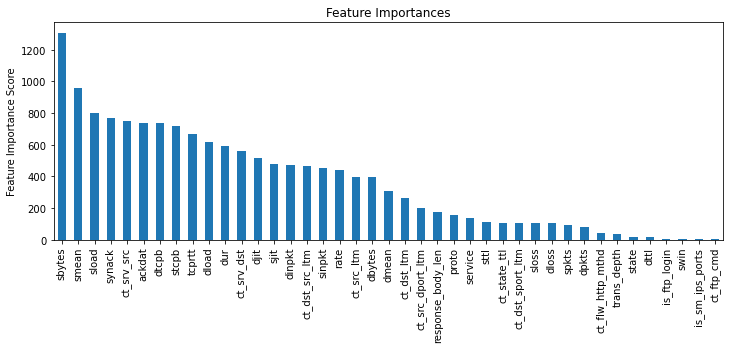

In [17]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1484,
        max_depth=4,
        min_child_weight=12,
        gamma=0.4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, train, test, predictors)

In [18]:
# subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1484, max_depth=4,
 min_child_weight=12, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([ 748.54200873,  748.33966718,  754.1630981 ,  758.40649624,
          823.628093  ,  830.53890414,  836.6984724 ,  845.46243834,
          907.3901073 ,  914.08244901,  922.15662007,  931.83708663,
          989.34033957,  999.34366064, 1010.53597884, 1014.76679311]),
  'std_fit_time': array([ 1.4983344 ,  5.26715419,  7.09255571,  6.78998847,  2.66227534,
          5.41573563,  8.15318905,  5.12985675,  3.8220995 ,  7.64225501,
          6.78529294,  5.54525504,  5.22460208, 10.31855939, 11.81541678,
          5.15023143]),
  'mean_score_time': array([0.93164639, 0.88159971, 0.91281428, 1.06087508, 0.98185759,
         0.96294198, 0.90945134, 1.07278452, 0.92223482, 0.88476081,
         0.93682547, 0.95000062, 0.97560196, 1.05783224, 0.95388198,
         0.79203324]),
  'std_score_time': array([0.10161406, 0.09360645, 0.13115296, 0.14353376, 0.12975513,
         0.13066709, 0.07109229, 0.09577466, 0.05506742, 0.04910119,
         0.05081225, 0.04250329, 0.018

In [21]:
# subsample and colsample_bytree
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1484, max_depth=4,
 min_child_weight=12, gamma=0.4, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,cv=5)
gsearch5.fit(train[predictors],train[target])

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:06:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6,
                                     enable_categorical=False, gamma=0.4,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1484, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_we

In [22]:
# alpha (regularization paramter)
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1484, max_depth=4,
 min_child_weight=12, gamma=0.4, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([812.81040015, 862.51195869, 811.7281651 , 780.75140615,
         645.04114671]),
  'std_fit_time': array([ 23.60141625,   5.64139992,  34.53603714,   2.12911998,
         204.03528189]),
  'mean_score_time': array([3.92816186, 3.65320826, 2.31476493, 1.01970897, 0.85922222]),
  'std_score_time': array([2.04482127, 2.32196406, 2.04028899, 0.07107676, 0.19822803]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.99554479, 0.995498  , 0.99543291, 0.99561399, 0.99576716]),
  'split1_test_score': array([0.99859201, 0.99858212, 0.99857269, 0.99858684, 0.99858972]),
  'split2_test_score': array([0.99923542, 0.99923541, 0.99923938, 0.9992186 , 0.9991937 ]),
  'split3_test_score'